In [8]:
from pathlib import Path
from typing import Collection
import pandas as pd
import re
from pedpy import TrajectoryData

def extract_trajectories(input_file: Path) -> Collection[TrajectoryData]:
    # Extract dataframes from input_file and dividing in multiple df according to group col
    df = pd.read_csv(
                input_file,
                sep=r"\s+",
                comment="#",
                header=None,
                names=['id', 'frame', 'x', 'y', 'group'],
                usecols=[0, 1, 2, 3, 5],
    )
    groups = df['group'].unique()
    
    dfs = {}
    for group in groups:
        dfs[group] = df.loc[df['group'] == group]
    
    # Get fps from input_file
    with open(input_file, 'r') as file:
        first_line = file.readline().strip()
    
    match = re.search(r'# framerate: (\d+) fps', first_line)
    if not match:
        raise Exception('fps not found in trajectory file')
    fps = int(match.group(1))
    
    # Create a collection of TrajectoryData
    trajectories = []
    for df in dfs.values():
        traj = TrajectoryData(df, fps)
        trajectories.append(traj)
        
    return trajectories

In [9]:
from pedpy import WalkableArea
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

def plot_trajectories(trajectories: Collection[TrajectoryData], walkable_area: WalkableArea) -> None:

    for traj, color in zip(trajectories, ['#FF0000', '#0000FF', '#00FF00', '#FFFFFF']):
        plot_measurement_setup(
            walkable_area=walkable_area,
            traj=traj,
            traj_color=color,
            traj_alpha=0.5,
            traj_width=1,
            ma_line_width=2,
            ma_alpha=0.5,
        ).set_aspect("equal")

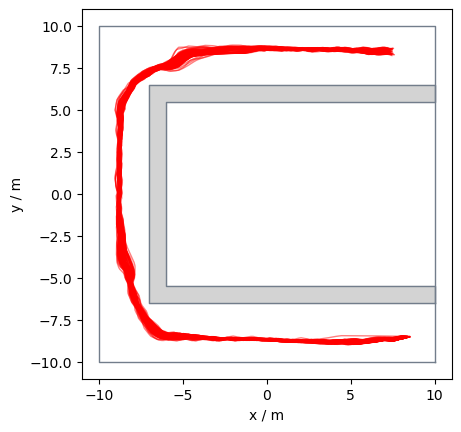

In [10]:
curve_c_area = WalkableArea(
    # Complete area (outer boundary)
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom barrier
        [
            (9.999, -6.5),
            (-7, -6.5),
            (-7, 6.5),
            (9.999, 6.5),
            (9.999, 5.5),
            (-6, 5.5),
            (-6, -5.5),
            (9.999, -5.5),
        ],
        
    ],
)

curve_c_traj = extract_trajectories(
    Path("../output/pedpy/CurveCBatch.txt")
)

plot_trajectories(curve_c_traj, curve_c_area)
plt.show()

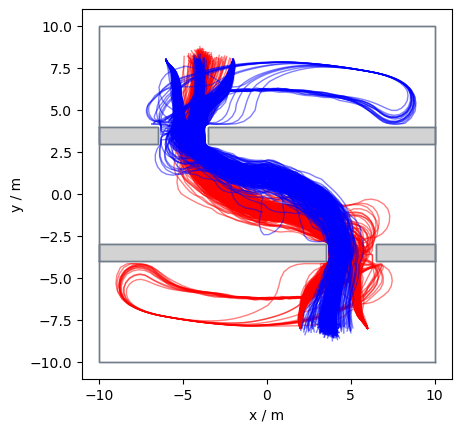

In [11]:
double_door_opposite_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom right barrier
        [
            (9.999, -4.0),
            (6.5, -4.0),
            (6.5, -3.0),
            (9.999, -3.0)
        ],
        # bottom left barrier
        [
            (-9.999, -4.0),
            (3.5, -4.0),
            (3.5, -3.0),
            (-9.999, -3.0)
        ],
        # top right barrier
        [
            (-9.999, 4.0),
            (-6.5, 4.0),
            (-6.5, 3.0),
            (-9.999, 3.0)
        ],
        # top left barrier
        [
            (9.999, 4.0),
            (-3.5, 4.0),
            (-3.5, 3.0),
            (9.999, 3.0)
        ],
      
        
    ],
)

double_door_opposite_traj = extract_trajectories(
    Path("../output/pedpy/DoubleDoorOppositeBatch.txt")
)

plot_trajectories(double_door_opposite_traj, double_door_opposite_area)
plt.show()

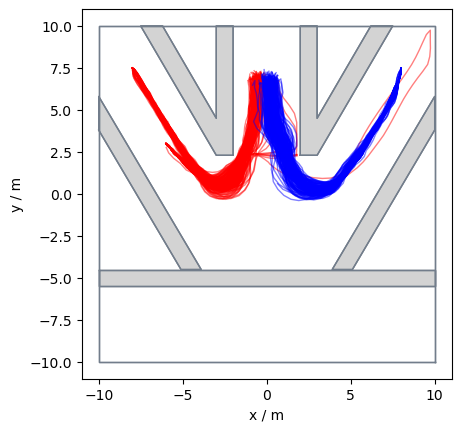

In [12]:
anchor_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom left barrier
        [
            (-9.999, 3.8),
            (-9.999, 5.8),
            (-3.9, -4.5),
            (-5.1, -4.5),
        ],
        #top left anchor
        [
            (-2.0, 2.3),
            (-2.0, 9.999),
            (-3.0, 9.999),
            (-3.0, 4.5),
            (-6.2, 9.999),
            (-7.5, 9.999),
            (-3.0, 2.3),
        ],
        # bottom right barrier
        [
            (9.999, 3.8),
            (9.999, 5.8),
            (3.9, -4.5),
            (5.1, -4.5),
        ],
        #top left anchor
        [
            (2.0, 2.3),
            (2.0, 9.999),
            (3.0, 9.999),
            (3.0, 4.5),
            (6.2, 9.999),
            (7.5, 9.999),
            (3.0, 2.3),
        ],
        #bottom barrier
        [
            (-9.999, -4.51),
            (9.999, -4.51),
            (9.999, -5.5),
            (-9.999, -5.5),
        ]
        
    ],
)

anchor_traj = extract_trajectories(
    Path("../output/pedpy/AnchorBatch.txt")
)

plot_trajectories(anchor_traj, anchor_area)
plt.show()

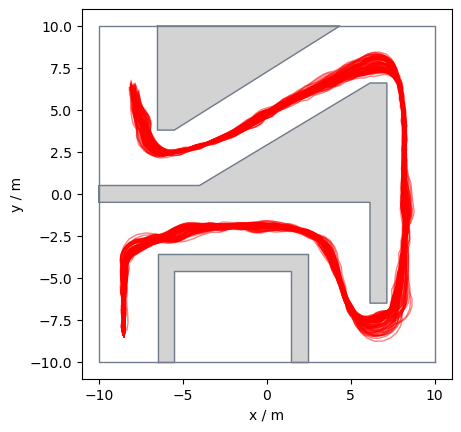

In [13]:
omega_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom left barrier
        [
            (-6.5, -9.999),
            (-6.5, -3.6),
            (2.45, -3.6),
            (2.45, -9.999),
            (1.45, -9.999),
            (1.45, -4.6),
            (-5.5, -4.6),
            (-5.5, -9.999),
        ],    
        # mid barrier
        [
            (-9.999, -0.5),
            (6.15, -0.5),
            (6.15, -6.5),
            (7.15, -6.5),
            (7.15, 6.6),
            (6.15, 6.6),
            (-4.0, 0.5),
            (-9.999, 0.5),
        ],
        [
            (-6.5, 9.999),
            (-6.5, 3.8),
            (-5.5, 3.8),
            (4.35, 9.999),
            (2.45, 9.999),
            
        ]
    ],
)

omega_traj = extract_trajectories(
    Path("../output/pedpy/OmegaBatch.txt")
)

plot_trajectories(omega_traj, omega_area)
plt.show()

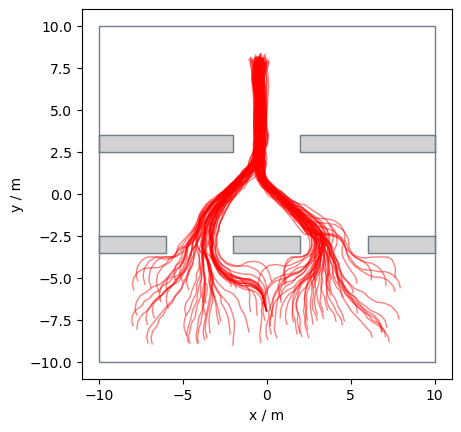

In [14]:
door_choice_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        [
            (-9.999, 2.5),
            (-9.999, 3.5),
            (-2.0, 3.5),
            (-2.0, 2.5),
        ],
        [
            (9.999, 2.5),
            (9.999, 3.5),
            (2.0, 3.5),
            (2.0, 2.5),
        ],
        [
            (-9.999, -2.5),
            (-9.999, -3.5),
            (-6.0, -3.5),
            (-6.0, -2.5),
        ],
        [
            (9.999, -2.5),
            (9.999, -3.5),
            (6.0, -3.5),
            (6.0, -2.5),
        ],
        [
            (-2.0, -2.5),
            (-2.0, -3.5),
            (2.0, -3.5),
            (2.0, -2.5),
        ],

    ],
)

door_choice_traj = extract_trajectories(
    Path("../output/pedpy/DoorChoiceBatch.txt")
)

plot_trajectories(door_choice_traj, door_choice_area)
plt.show()